# Credit Card Transaction Analysis



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
def desc_stats(df):
    desc = df.describe(include='all').T
    desc['missing'] = df.isnull().sum()
    desc['unique'] = df.nunique()
    desc['dtype'] = df.dtypes
    # Reorder columns for better readability
    cols = ['dtype', 'count', 'unique', 'missing', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'top', 'freq']
    # Only include columns that exist in desc
    cols = [c for c in cols if c in desc.columns]
    return desc[cols]


In [6]:
df = pd.read_csv("/content/credit_card_transactions.csv", parse_dates=['trans_date_trans_time', 'dob'])
df.drop(columns=['Unnamed: 0', 'merch_zipcode'], inplace=True) # too much null values


df.head(2)

# descriptive stats
desc_stats(df)


,dtype,count,unique,missing,mean,std,min,25%,50%,75%,max,top,freq
trans_date_trans_time,datetime64[ns],1296675,1274791,0,2019-10-03 12:47:28.070214144,NaN,2019-01-01 00:00:18,2019-06-03 19:12:22.500000,2019-10-03 07:35:47,2020-01-28 15:02:55.500000,2020-06-21 12:13:37,NaN,NaN
cc_num,int64,1296675.0,983,0,417192042079726656.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0,NaN,NaN
merchant,object,1296675,693,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fraud_Kilback LLC,4403
category,object,1296675,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas_transport,131659
amt,float64,1296675.0,52928,0,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9,NaN,NaN
first,object,1296675,352,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Christopher,26669
last,object,1296675,481,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Smith,28794
gender,object,1296675,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,709863
street,object,1296675,983,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,864 Reynolds Plains,3123
city,object,1296675,894,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham,5617


# EDA

In [7]:

###### DATA TRANSFORMATION - FEATURE ENGINEERING ##############

df['customer_age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

## Time Series



*   Strong cyclical rhythm: Spending rises and falls at regular, tightly spaced intervals—consistent with a weekly pattern (e.g., weekend vs. weekday effects).

*   Gradual upward drift through Q1 - Q3 '19: Early 2019 daily totals hover between ~\$75k and \$175k; and mid-2019 peaks climb toward \$250k.
* Amplitude growth: The highs and lows widen over time; troughs deepen slightly while peaks climb higher, signalling increasing volatility or larger transaction batches later in the year.
* Sharp surge in late 2019 → early 2020:
  - A cluster of outsized peaks surpassing $450 k marks the highest activity in the series.
  - Likely tied to holiday promotions, year-end bonuses, or large one-off purchases.
* Post-spike correction with elevated baseline:
  - After the January 2020 peak, spending falls back but stabilises around \$150 k–\$250 k, still higher than early-2019 levels.
  - Periodic cycles persist, indicating seasonal or behavioural forces remain in play.

In [12]:
df["transaction_date"] = df["trans_date_trans_time"].dt.date
daily_spending = df.groupby("transaction_date")["amt"].sum().reset_index()

fig = px.line(
    daily_spending,
    x="transaction_date",
    y="amt",
    title="Daily Spending Trends",
    labels={"transaction_date": "Date", "amt": "Total Amount Spent ($)"}
)
fig.update_xaxes(tickangle=45)
fig.show()

* Monday and Sunday exhibit the highest total spend, each surpassing $17M, suggesting both the start and end of the week drive the largest transaction volumes.

* Midweek days (Tuesday through Friday) show noticeably lower spend, with Wednesday being the lowest. This pattern may reflect shifts in consumer activity or business cycles.

* Spending is not uniformly distributed across all hours:

  - Evening hours (20:00–23:00) on Mondays and Sundays consistently see the highest concentration of spending, as shown in the heatmap’s darkest cells.
  - Early morning and late-night hours (0:00–5:00) maintain moderate spend on Mondays and Sundays but are much lighter on midweek days.

* Monday displays a more evenly distributed spending pattern throughout the day compared to other weekdays, which show lower mid-day activity.

* Weekends (Saturday and Sunday) show a broader spread of high spend across late morning to evening, indicating a gradual buildup rather than a single sharp peak.

In [20]:
df['weekday'] = df['trans_date_trans_time'].dt.day_name()
df['hour'] = df['trans_date_trans_time'].dt.hour
wkly = (df.groupby('weekday')
          .agg(total_spend = ('amt',  'sum'),
               tx_count    = ('amt',  'size'))
          .reindex(['Monday','Tuesday','Wednesday','Thursday',
                    'Friday','Saturday','Sunday']))

pivot = (df.groupby(['weekday','hour'])['amt']
           .sum()
           .reset_index()
           .pivot(index='weekday', columns='hour', values='amt')
           .reindex(['Monday','Tuesday','Wednesday','Thursday',
                     'Friday','Saturday','Sunday']))

fig1 = px.bar(wkly, x=wkly.index, y='total_spend',
              title='Total Spend by Weekday',
              labels={'x':'Weekday','total_spend':'Spend ($)'})
fig1.update_layout(xaxis_title=None); fig1.show()

# Heat-map: spend by weekday & hour
fig2 = px.imshow(pivot,
                 labels=dict(x='Hour of Day', y='Weekday', color='Spend ($)'),
                 title='Heat-Map of Spend (Weekday × Hour)',
                 aspect='auto', color_continuous_scale='Blues')
fig2.update_xaxes(side='top'); fig2.show()

In [21]:
df['day_in_month'] = df['trans_date_trans_time'].dt.day

# Aggregate total spend by day in month
day_spend = df.groupby('day_in_month')['amt'].sum().reset_index()

# Plot
fig = px.bar(
    day_spend, x='day_in_month', y='amt',
    title='Total Spending by Day in Month',
    labels={'day_in_month': 'Day of Month', 'amt': 'Total Spend ($)'}
)
fig.show()

## Time Series Forecasting with Facebook Prophet

* Prophet is an open-source time series forecasting library developed by Facebook’s Core Data Science team.
* Designed for business analysts and data scientists—easy to use, robust to missing data, outliers, and trend shifts.
* Particularly strong for daily, weekly, or yearly seasonality (e.g., sales, app usage, web traffic, financial transactions).

### Data Preparation

In [22]:
### data preprocessing
# handle outliers and skewness

from scipy.stats import skew

# cal skewness
original_skewness = skew(df["amt"])
print("Skewness before log transformation:", original_skewness)

# remove outliers
IQR = df["amt"].quantile(0.75) - df["amt"].quantile(0.25)

lower_bound = df["amt"].quantile(0.25) - 1.5 * IQR
upper_bound = df["amt"].quantile(0.75) + 1.5 * IQR

#  Cap Outliers (Winsorization)
df["amt"] = np.where(df["amt"] < lower_bound, lower_bound, df["amt"])
df["amt"] = np.where(df["amt"] > upper_bound, upper_bound, df["amt"])

# Recalculate skewness after handling outliers
cleaned_skewness = skew(df["amt"])
print("Skewness after handling outliers:", cleaned_skewness)

# Apply log transformation permanently:
df["amt"] = np.log1p(df["amt"])  # log(amt + 1) to handle zero values

# Calculate skewness after transformation:
transformed_skewness = skew(df["amt"])
print("Skewness after log transformation:", transformed_skewness)

Skewness before log transformation: 42.2778248827837
Skewness after handling outliers: 1.0619621755092699
Skewness after log transformation: -0.5351445480954713



Skewness before log transformation: 42.3:
- Extremely high positive skew: The distribution of amt (transaction amount) is heavily right-skewed. Most values are small, but there are a few very large transactions that stretch the upper end of the scale.
- This is typical for financial/transactional data where most spends are small but rare outliers can be huge.

Skewness after handling outliers (Winsorization): 1.06
- After capping outliers using the IQR rule (Winsorization), skewness drops to just above 1.
- The distribution is still right-skewed, but far less extreme—most values are now within a reasonable range, with the “long tail” cut off.
- Winsorization helps reduce the influence of outliers, which can improve stability in downstream modeling.

Skewness after log transformation: -0.53
- Slightly left-skewed, nearly symmetric.
- Log transformation compresses high values much more than low values, pulling the right tail in and centering the data.
- Slight negative skewness (–0.53) is generally acceptable; your distribution is now much closer to normal (bell-shaped), which is optimal for many statistical models.
- Log transformation also makes effects additive (vs. multiplicative), aiding interpretation and forecast modeling.



In [23]:
# Aggregate transactions by day
df_prophet = df.groupby("transaction_date")["amt"].sum().reset_index()

# Rename columns for Prophet
df_prophet.columns = ["ds",  "y"]  # 'ds' = date, 'y' = target variabl

df_prophet.head()

,ds,y
0,2019-01-01,8331.115095
1,2019-01-02,3884.604087
2,2019-01-03,4359.996276
3,2019-01-04,5251.381450
4,2019-01-05,4968.719704


### Model Training

In [25]:
from prophet import Prophet

In [26]:
# Initialize the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)  # Add monthly seasonality

# Fit the model
model.fit(df_prophet)

# Create a future dataframe (e.g., forecast next 30 days)
future = model.make_future_dataframe(periods=30,freq="D")

# Make predictions
forecast = model.predict(future)

# Display predictions
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzm6vg5d/3rsas_3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgzm6vg5d/yvjr75tu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9239', 'data', 'file=/tmp/tmpgzm6vg5d/3rsas_3e.json', 'init=/tmp/tmpgzm6vg5d/yvjr75tu.json', 'output', 'file=/tmp/tmpgzm6vg5d/prophet_model36kecgg1/prophet_model-20250720155353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
562,2020-07-17,8764.248846,6675.916504,10768.300544
563,2020-07-18,10778.097776,8711.276923,12886.405785
564,2020-07-19,12574.197241,10503.099705,14589.992550
565,2020-07-20,12768.443110,10736.026590,14675.467158
566,2020-07-21,8425.558932,6471.295689,10356.134061


### Forecast Visualization

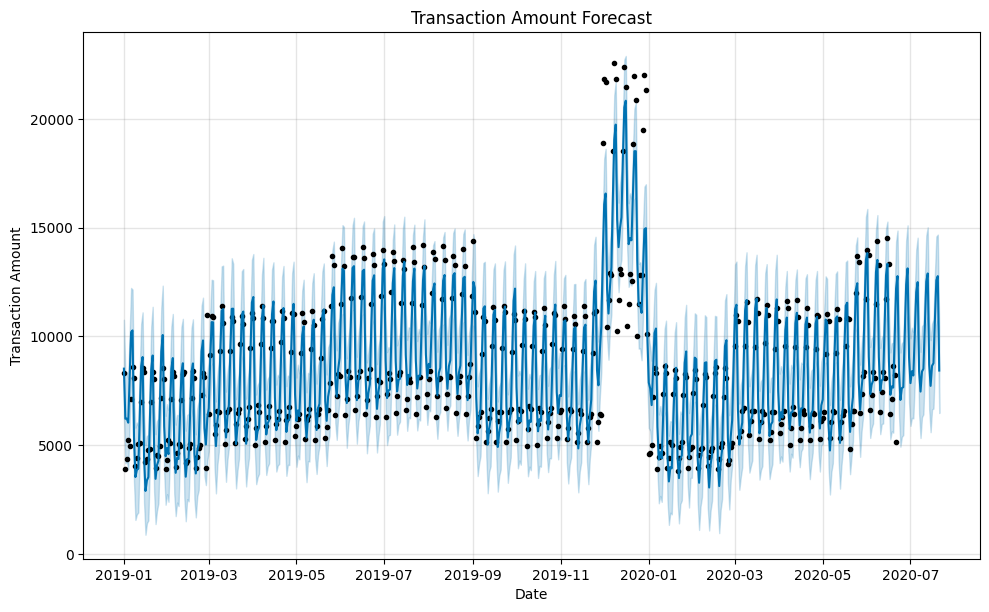

In [27]:
# Plot forecast
fig = model.plot(forecast)
plt.title("Transaction Amount Forecast")
plt.xlabel("Date")
plt.ylabel("Transaction Amount")

# Save the figure
plt.savefig("transaction_forecast.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

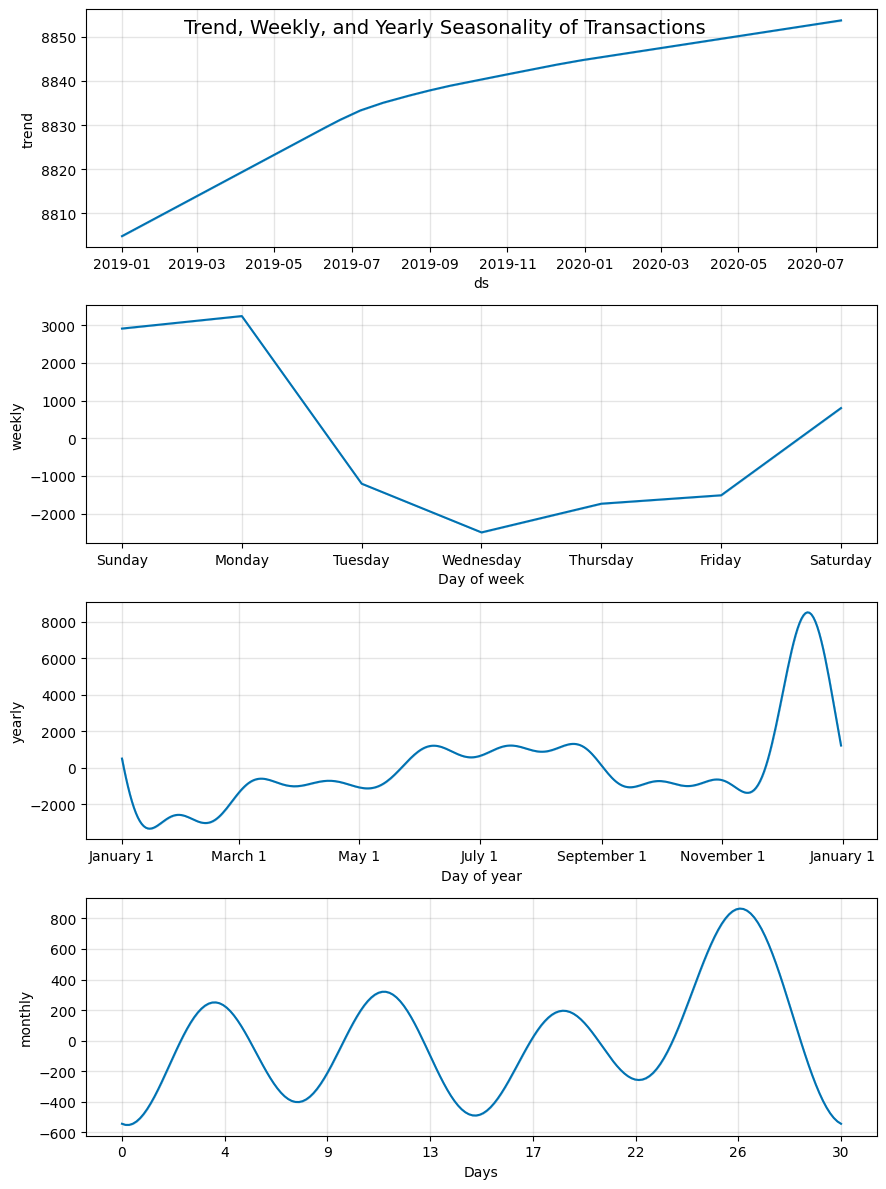

In [28]:
# Visualize trend, weekly seasonality, and yearly seasonality
fig_components = model.plot_components(forecast)

# Add a main title
fig_components.suptitle("Trend, Weekly, and Yearly Seasonality of Transactions", fontsize=14)

# Save the figure
fig_components.savefig("transaction_components.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### Forecast Evaluation

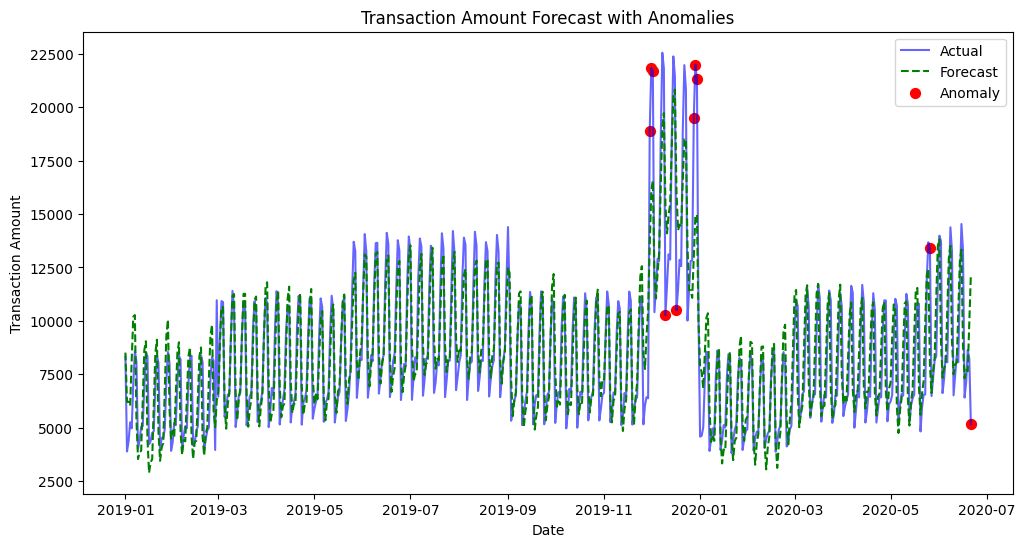

In [41]:
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
forecast["ds"] = pd.to_datetime(forecast["ds"])

df_prophet = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")
df_prophet["residual"] = df_prophet["y"] - df_prophet["yhat"] # Compute residuals


# Define threshold for anomaly detection (3 * std)
threshold = 3 * np.std(df_prophet["residual"])
df_prophet["anomaly"] = np.abs(df_prophet["residual"]) > threshold  # Mark anomalies

# anomalies viz
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", color="blue", alpha=0.6)
plt.plot(df_prophet["ds"], df_prophet["yhat"], label="Forecast", color="green", linestyle="dashed")

anomalies = df_prophet[df_prophet["anomaly"]] ## highlight anomalies
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomaly", marker="o", s=50)

plt.xlabel("Date")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount Forecast with Anomalies")
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_prophet["y"], df_prophet["yhat"])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(df_prophet["y"], df_prophet["yhat"])
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 1101.303962880213
Mean Squared Error (MSE): 2575509.4104066663
Root Mean Squared Error (RMSE): 1604.8393721512027
R-squared (R²): 0.7825450417963025


In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ── 1.  Identify boundaries ────────────────────────────────────────────────
last_history_date = df_prophet['ds'].max()    # last date with actual y

# Separate historical & future slices
hist = forecast[forecast['ds'] <= last_history_date]
future_fcst = forecast[forecast['ds'] >  last_history_date]

# ── 2.  Build interactive figure ───────────────────────────────────────────
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Actuals
fig.add_trace(
    go.Scatter(
        x=df_prophet['ds'], y=df_prophet['y'],
        name='Actual', mode='lines', line=dict(color='royalblue')
    )
)

# Fitted predictions (in-sample)
fig.add_trace(
    go.Scatter(
        x=hist['ds'], y=hist['yhat'],
        name='Fitted', mode='lines', line=dict(color='green', dash='dash')
    )
)

# Future forecast
fig.add_trace(
    go.Scatter(
        x=future_fcst['ds'], y=future_fcst['yhat'],
        name='Forecast (next 30 d)', mode='lines',
        line=dict(color='darkorange')
    )
)

# Confidence interval ribbon for future
fig.add_trace(
    go.Scatter(
        x=pd.concat([future_fcst['ds'], future_fcst['ds'][::-1]]),
        y=pd.concat([future_fcst['yhat_upper'], future_fcst['yhat_lower'][::-1]]),
        fill='toself', fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,165,0,0)'), showlegend=False,
        hoverinfo="skip"
    )
)

# ── 3.  Layout tweaks ─────────────────────────────────────────────────────
fig.update_layout(
    title='Daily Transaction Amount – Historical & 30-Day Forecast',
    xaxis_title='Date',
    yaxis_title='Transaction Amount',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()

**Model Evaluation**

The Prophet forecasting model achieved the following performance metrics on the historical transaction data:
- **Mean Absolute Error (MAE):** 1,101
- **Root Mean Squared Error (RMSE):** 1,605
- **R-squared (R²):** 0.78

This indicates that the model explains approximately 78% of the variance in daily transaction amounts, with a typical forecast error (MAE) of about $1,100 per day. The model’s accuracy is solid, but several spikes and drops remain challenging to predict due to their irregular nature.

**Anomaly Detection**

To highlight unexpected events or outliers, anomaly detection was performed using residuals (the difference between actual and predicted values). Any day where the absolute residual exceeded three times the standard deviation was flagged as an anomaly.

The plot above visualizes:
- **Actual daily amounts** (blue line)
- **Prophet forecast** (green dashed line)
- **Detected anomalies** (red dots)

Major anomalies correspond to large positive or negative residuals, typically seen during periods of extreme spend spikes (e.g., end-of-year holidays or one-off events) that the model did not anticipate.

**Business Implications**

- **Anomalous spikes** likely correspond to major promotional campaigns, holidays, or operational changes. These events should be investigated for underlying causes and, if recurring, incorporated into the forecasting model as holiday regressors.
- **Steady baseline prediction** supports daily planning for typical transaction volumes.
- The current approach can be enhanced by including additional features (holidays, campaign flags), or external factors like economic trends, or by trying other models for highly volatile periods.
